## Embedding viz

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-12 17:12:05.320370: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-12 17:12:05.568555: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-12 17:12:05.769219: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-12 17:12:05.770460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)


<module 'data.data_utils' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_utils.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 32.6%
RAM Usage: 20.3%
Available RAM: 1.2T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


### Setup

In [6]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric
from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

from data.data_viz import plot_umap_embeddings_w_fc, plot_spectral_embedding_w_fc, plot_coords_w_fc

Loading data...
Number of components for 95% variance PCA: 27


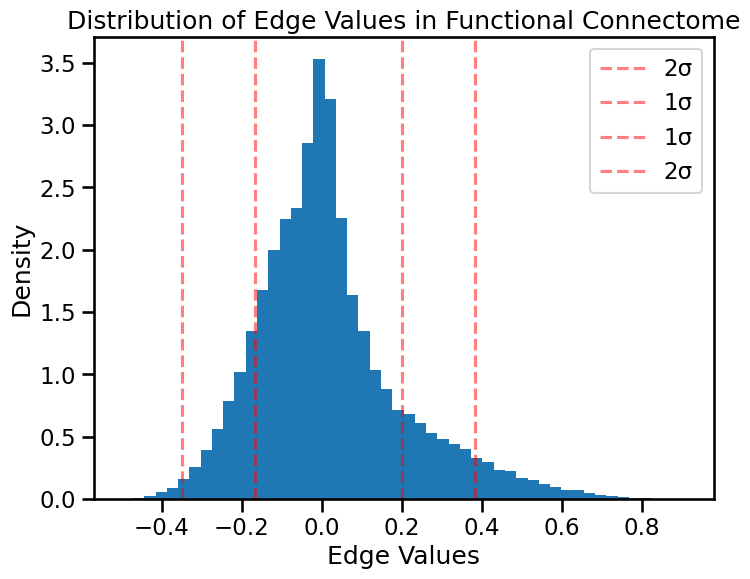

In [7]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_umap_embeddings_w_fc

### SMT POOL EMBEDDINGS ###
from models.smt import SharedSelfAttentionPoolingModel, SharedSelfAttentionCLSPoolingModel

# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')

### PCA ###
X_pca = load_transcriptome(parcellation='S456', run_PCA='95var', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X_valid = X[valid_indices]
X_pca = X_pca[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Plot histogram of edge values
plt.figure(figsize=(8, 6))
plt.hist(Y.flatten(), bins=50, density=True)

# Add std dev markers
mean = np.mean(Y)
std = np.std(Y)
for i in [-2, -1, 1, 2]:
    plt.axvline(mean + i*std, color='r', linestyle='--', alpha=0.5, 
                label=f'{i}σ' if i > 0 else f'{abs(i)}σ')

plt.xlabel('Edge Values')
plt.ylabel('Density')
plt.title('Distribution of Edge Values in Functional Connectome')
plt.legend()
plt.show()

PCA and PLS

In [8]:
# Project X to PCs explaining 95% variance explained
print(f"X_pca shape: {X_pca.shape}")

### PLS ###
# Project X to 10 PLS components
pls_model = PLSRegression(n_components=10, max_iter=1000, scale=True)
pls_model.fit(X_valid, Y_valid)

# Use x_rotations_ for fixed projection like in PLSEncoder
X_pls = np.matmul(X_valid, pls_model.x_rotations_)
print(f"X_pls shape: {X_pls.shape}")

X_pca shape: (455, 27)
X_pls shape: (455, 10)


In [9]:
# prepare data loader
X = torch.tensor(X_valid, dtype=torch.float32).to("cuda") 
coords = torch.tensor(coords_valid, dtype=torch.float32).to("cuda")
dataset = TensorDataset(X, coords)
dataloader = DataLoader(dataset, batch_size=X_valid.shape[0], shuffle=False)

Bilinear Lowrank

In [10]:
from models.bilinear import BilinearLowRank

# Load saved bilinear lowrank model
blr_model = BilinearLowRank(
    input_dim=X_valid.shape[1]*2,  # *2 since model expects concatenated pairs
    reduced_dim=10,
    activation='none',
    learning_rate=0.0001, 
    batch_size=256,
    regularization='l2',
    lambda_reg=0.001,
    shared_weights=True,
    epochs=125
).to("cuda")

# Load saved weights
model_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_blr_full.pt"
blr_model.load_state_dict(torch.load(model_path))
blr_model.eval()

# Extract embeddings using encoder (linear layer)
with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        # Since activation is identity, we can just use linear layer
        embeddings_blr = blr_model.linear(X)
        embeddings_blr = embeddings_blr.cpu().numpy()

print(f"Bilinear lowrank embeddings shape: {embeddings_blr.shape}")

Number of learnable parameters in Bilinear low rank model: 73800
  Linear layer 1: 73800 parameters


  warnings.warn(



Bilinear lowrank embeddings shape: (455, 10)


MLP

In [11]:
from models.dynamic_mlp import DynamicMLP

# Load saved MLP model with best hyperparameters
mlp_model = DynamicMLP(
    input_dim=X_valid.shape[1]*2, # *2 since we concatenate X with itself
    hidden_dims=[512, 256, 128],
    learning_rate=0.00009,
    batch_size=512,
    dropout_rate=0.1,
    weight_decay=0.0001,
    epochs=125
).to("cuda")

# Load saved weights
model_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_mlp_full.pt"
mlp_model.load_state_dict(torch.load(model_path))
mlp_model.eval()

# Extract embeddings from last hidden layer before prediction
with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        # Concatenate X with itself
        X_concat = torch.cat([X, X], dim=1)
        # Get all layers except final prediction layer
        layers = list(mlp_model.model.children())[:-1]
        # Create new model up to last hidden layer
        hidden_model = nn.Sequential(*layers)
        # Get embeddings
        embeddings_mlp = hidden_model(X_concat)
        embeddings_mlp = embeddings_mlp.cpu().numpy()

print(f"MLP embeddings shape: {embeddings_mlp.shape}")


Number of learnable parameters in MLP: 7723777
MLP embeddings shape: (455, 128)


In [12]:
# Load saved MLP model with best hyperparameters
mlpcoords_model = DynamicMLP(
    input_dim=X_valid.shape[1]*2+2*coords_valid.shape[1], # *2 since we concatenate X with itself
    hidden_dims=[512, 256, 128],
    learning_rate=0.00009,
    batch_size=512,
    dropout_rate=0.1,
    weight_decay=0.0001,
    epochs=125
).to("cuda")

# Load saved weights
model_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_mlpcoords_full.pt"
mlpcoords_model.load_state_dict(torch.load(model_path))
mlpcoords_model.eval()

# Extract embeddings from last hidden layer before prediction
with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        # Concatenate X with itself
        X_concat = torch.cat([X, coords, X, coords], dim=1)
        # Get all layers except final prediction layer
        layers = list(mlpcoords_model.model.children())[:-1]
        # Create new model up to last hidden layer
        hidden_model = nn.Sequential(*layers)
        # Get embeddings
        embeddings_mlpcoords = hidden_model(X_concat)
        embeddings_mlpcoords = embeddings_mlpcoords.cpu().numpy()

print(f"MLP embeddings shape: {embeddings_mlpcoords.shape}")

Number of learnable parameters in MLP: 7726849
MLP embeddings shape: (455, 128)


SMT base models

In [13]:
from env.imports import *
from data.data_utils import create_data_loader
from models.train_val import train_model
import torch.nn.functional as F
from flash_attn import flash_attn_func, flash_attn_qkvpacked_func
from torch.cuda.amp import autocast

# DEFINE TRUE ORIGINAL SMT MODELS
def scaled_dot_product_attention_with_weights(query, key, value, dropout_p=0.0, is_causal=False, scale=None):
    '''
    Helper function to compute attention output and weights at inference
    '''
    # similar to https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html#torch.nn.functional.scaled_dot_product_attention for inference
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    scores = torch.matmul(query, key.transpose(-2, -1)) * scale_factor
    weights = torch.softmax(scores, dim=-1)
    weights = F.dropout(weights, p=dropout_p, training=True)
    output = torch.matmul(weights, value)
    return output, weights

def plot_avg_attention(avg_attn):
    '''
    Helper function to plot average attention weights
    '''
    nhead = avg_attn.shape[0]
    for h in range(nhead):
        plt.figure(figsize=(6, 5))
        vmin, vmax = avg_attn[h].min(), avg_attn[h].max()
        plt.imshow(avg_attn[h], cmap="viridis", vmin=vmin, vmax=vmax)
        plt.colorbar(label=f"Attention Weight [{vmin:.2f}, {vmax:.2f}]")
        plt.title(f"Average Attention Head {h}")
        plt.xlabel("Key")
        plt.ylabel("Query") 
        plt.show()

# === FAST TRANSFORMER IMPLEMENTATION === #
class FastSelfAttentionBlock(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1, use_alibi=False):
        super().__init__()
        self.nhead = nhead
        self.head_dim = d_model // nhead

        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_norm = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.ffn_norm = nn.LayerNorm(d_model)

        # Store attention weights
        self.store_attn = False
        self.last_attn_weights = None

        self.use_alibi = use_alibi
        if use_alibi:
            slopes = self.build_alibi_slopes(nhead)
            self.register_buffer("alibi_slopes", slopes)

    def split_heads(self, x):
        return x.view(x.size(0), x.size(1), self.nhead, self.head_dim).transpose(1, 2)

    def merge_heads(self, x):
        return x.transpose(1, 2).reshape(x.size(0), x.size(2), -1)

    @staticmethod
    def build_alibi_slopes(n_heads):
        slopes = []
        base = 2.0
        for i in range(n_heads):
            power = i // (n_heads // base)
            slopes.append(1.0 / (base ** power))
        return torch.tensor(slopes).float()

    def forward(self, x):
        with autocast(dtype=torch.bfloat16):
            residual = x

            # Project QKV jointly
            qkv = self.qkv_proj(x)  # (B, L, 3 * d_model)
            if self.store_attn:
                q, k, v = qkv.chunk(3, dim=-1)
                q = self.split_heads(q)  # (B, nhead, L, head_dim)
                k = self.split_heads(k)
                v = self.split_heads(v)
                # Manual scaled dot-product attention
                attn_output, attn_weights = scaled_dot_product_attention_with_weights(q, k, v, dropout_p=0.0, is_causal=False)
                self.last_attn_weights = attn_weights.detach().cpu()
                attn_output = self.merge_heads(attn_output)
            else:
                qkv = qkv.view(x.size(0), x.size(1), 3, self.nhead, self.head_dim)  # (B, L, 3, nhead, head_dim)
                attn_output = flash_attn_qkvpacked_func(
                    qkv,
                    dropout_p=0.0,
                    causal=False,
                    alibi_slopes=self.alibi_slopes if self.use_alibi else None
                )
                # ALiBi indicates positionality in the transformer by simply modifying the attention mechanism,
                # biasing the attention mechanism to have words that are away from each other interact less than words that are nearby.
                attn_output = attn_output.transpose(1, 2)  # (B, nhead, L, head_dim)
                attn_output = self.merge_heads(attn_output)
            attn_output = self.attn_dropout(attn_output)

            x = self.attn_norm(residual + attn_output)
            residual = x

            x = self.ffn(x)
            x = self.ffn_norm(residual + x)

            return x

class FastSelfAttentionEncoder(nn.Module):
    def __init__(self, token_encoder_dim, d_model, output_dim, nhead=4, num_layers=4, dropout=0.1, use_alibi=False):
        super().__init__()
        self.input_projection = nn.Linear(token_encoder_dim, d_model)
        self.layers = nn.ModuleList([
            FastSelfAttentionBlock(d_model, nhead, dropout, use_alibi=use_alibi)
            for _ in range(num_layers)
        ])
        self.output_projection = nn.Linear(d_model, output_dim)

    def forward(self, x):
        batch_size, total_features = x.shape
        L = total_features // self.input_projection.in_features
        x = x.view(batch_size, L, -1)
        x = self.input_projection(x)

        for layer in self.layers:
            x = layer(x)

        x = self.output_projection(x)
        x = x.flatten(start_dim=1)
        return x

class SharedSelfAttentionModel(nn.Module): # true name FastSharedSelfAttentionModel
    def __init__(self, input_dim, binarize=False, token_encoder_dim=20, d_model=128, encoder_output_dim=10, nhead=2, num_layers=2, deep_hidden_dims=[256, 128],
                 use_alibi=False, transformer_dropout=0.1, dropout_rate=0.1, learning_rate=0.001, weight_decay=0.0,
                 batch_size=256, aug_prob=0.0, epochs=100):
        super().__init__()
        
        self.binarize = binarize
        self.input_dim = input_dim // 2
        self.token_encoder_dim = token_encoder_dim
        self.d_model = d_model
        self.encoder_output_dim = encoder_output_dim
        self.nhead = nhead
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.epochs = epochs
        self.aug_prob = aug_prob
        self.use_alibi = use_alibi
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.encoder = FastSelfAttentionEncoder(
            token_encoder_dim=self.token_encoder_dim,
            d_model=self.d_model,
            output_dim=self.encoder_output_dim,
            nhead=self.nhead,
            num_layers=self.num_layers,
            dropout=transformer_dropout,
            use_alibi=self.use_alibi
        )
        self.encoder = torch.compile(self.encoder)

        prev_dim = (self.input_dim // self.token_encoder_dim * self.encoder_output_dim) * 2
        deep_layers = []
        for hidden_dim in deep_hidden_dims:
            deep_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim, dtype=torch.float32),
                nn.Dropout(dropout_rate)])
            prev_dim = hidden_dim
        self.deep_layers = nn.Sequential(*deep_layers)
        self.output_layer = nn.Linear(prev_dim, 1)

        self.optimizer = AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.criterion = nn.MSELoss()
        self.patience = 25
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.3,
            patience=20,
            threshold=0.1,
            cooldown=1,
            min_lr=1e-6,
            verbose=True
        )

    def forward(self, x):
        x_i, x_j = torch.chunk(x, chunks=2, dim=1)
        encoded_i = self.encoder(x_i)
        encoded_j = self.encoder(x_j)
        concatenated_embedding = torch.cat((encoded_i, encoded_j), dim=1)
        deep_output = self.deep_layers(concatenated_embedding)
        output = self.output_layer(deep_output)
        return output.squeeze()

    def predict(self, loader, collect_attn=False, save_attn_path=None):
        self.eval()
        predictions = []
        targets = []

        if collect_attn:
            for layer in self.encoder.layers:
                layer.store_attn = True
            avg_attn = None
            total_batches = 0

        with torch.no_grad():
            for batch_X, batch_y, batch_coords, _ in loader:
                batch_X = batch_X.to(self.device)
                batch_preds = self(batch_X).cpu().numpy()
                predictions.append(batch_preds)
                targets.append(batch_y.numpy())

                if collect_attn:
                    attn_weights = self.encoder.layers[-1].last_attn_weights
                    if attn_weights is not None:
                        # Mean across batch
                        batch_avg = attn_weights.mean(dim=0)  # (nhead, L, L)
                        if avg_attn is None:
                            avg_attn = batch_avg
                        else:
                            avg_attn += batch_avg
                        total_batches += 1

        predictions = np.concatenate(predictions)
        targets = np.concatenate(targets)

        if collect_attn and total_batches > 0:
            avg_attn /= total_batches  # Final average (nhead, L, L)
            plot_avg_attention(avg_attn.cpu())
            if save_attn_path is not None:
                np.save(save_attn_path, avg_attn.cpu().numpy())

        return ((predictions > 0.5).astype(int) if self.binarize else predictions), targets

    def fit(self, dataset, train_indices, test_indices, verbose=True):
        train_dataset = Subset(dataset, train_indices)
        test_dataset = Subset(dataset, test_indices)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, pin_memory=True)
        return train_model(self, train_loader, test_loader, self.epochs, self.criterion, self.optimizer, self.patience, self.scheduler, verbose=verbose, dataset=dataset)

# === SelfAttentionCLSEncoder using FastSelfAttentionBlock, FlashAttention, and CLS token === # 
class SelfAttentionCLSEncoder(nn.Module):    
    def __init__(self, token_encoder_dim, d_model, output_dim, nhead=4, num_layers=4, dropout=0.1, use_positional_encoding=False, cls_init='spatial_learned', use_alibi=False):
        super().__init__()
        self.token_encoder_dim = token_encoder_dim
        self.d_model = d_model
        self.use_positional_encoding = use_positional_encoding
        self.cls_init = cls_init
        self.use_alibi = use_alibi
        
        # Token projection
        self.input_projection = nn.Linear(token_encoder_dim, d_model)
        self.coord_to_cls = nn.Linear(3, d_model)
        
        @staticmethod
        def build_coord_remap_table(coord_tensor, seed=42, scale=100.0):
            '''
            Helper function for hash table to initialize coordinate vector randomly in deteterministic way
            '''
            torch.manual_seed(seed)
            remap = (torch.rand_like(coord_tensor) * 2 - 1) * scale  # [-100, 100]
            return remap
        
        # CLS token randomization/projection freeze
        if self.cls_init == 'random_learned':
            df = pd.read_csv('./data/UKBB/atlas-4S456Parcels_dseg_reformatted.csv')
            region_coords = torch.tensor(df.iloc[:, -3:].values, dtype=torch.float32)
            remap_tensor = self.build_coord_remap_table(region_coords)
            self.register_buffer("coord_ref_table", region_coords)
            self.register_buffer("coord_remap_table", remap_tensor)
        elif self.cls_init == 'spatial_fixed':
            self.coord_to_cls.weight.requires_grad = False
            self.coord_to_cls.bias.requires_grad = False            

        # Transformer layers
        self.layers = nn.ModuleList([
            FastSelfAttentionBlock(d_model, nhead, dropout, use_alibi=self.use_alibi)
            for _ in range(num_layers)
        ])

        # Register per-head ALiBi slopes once if use_alibi is True
        if self.use_alibi:
            slopes = FastSelfAttentionBlock.build_alibi_slopes(nhead)
            self.register_buffer("alibi_slopes", slopes)
            for layer in self.layers:
                layer.alibi_slopes = self.alibi_slopes

        self.output_projection = nn.Linear(d_model, output_dim)
    
    def replace_coords_with_remapped(self, coords):
        '''
        Helper function to replace true coordinates with randomized remapped coordinates
        '''
        B, _ = coords.shape
        match = (coords[:, None, :] == self.coord_ref_table[None, :, :]).all(dim=-1)
        idx = match.float().argmax(dim=1)
        remapped = self.coord_remap_table[idx]
        return remapped  # shape (B, 3)
    
    def forward(self, gene_exp, coords):
        batch_size, total_features = gene_exp.shape
        L = total_features // self.token_encoder_dim

        gene_exp = gene_exp.view(batch_size, L, self.token_encoder_dim)
        x_proj = self.input_projection(gene_exp)  # (B, L, d_model)

        if self.cls_init == 'random_learned': # Optionally replace true coordinates with randomized - like a summary token
            coords = self.replace_coords_with_remapped(coords)  # (B, 3)

        cls_token = self.coord_to_cls(coords).unsqueeze(1)  # (B, 1, d_model)
        x = torch.cat([cls_token, x_proj], dim=1)  # (B, L+1, d_model)

        for layer in self.layers:
            x = layer(x)

        x = self.output_projection(x)
        x = x.reshape(batch_size, -1)  # flatten all tokens including CLS
        # x = x[:, 0]  # return just the CLS token
        return x


class SharedSelfAttentionCLSModel(nn.Module):
    def __init__(self, input_dim, binarize=False, token_encoder_dim=20, d_model=128, encoder_output_dim=10, nhead=2, num_layers=2, deep_hidden_dims=[256, 128], 
                 use_positional_encoding=False, cls_init='spatial_learned', use_alibi=False, transformer_dropout=0.1, dropout_rate=0.1, learning_rate=0.001, weight_decay=0.0, 
                 batch_size=128, epochs=100, aug_prob=0.0):
        super().__init__()
        
        self.binarize = binarize 
        self.include_coords = True
        self.cls_init = cls_init # 'random_learned' 'spatial_fixed' 'spatial_learned' 
        self.aug_prob = aug_prob
        self.use_alibi = use_alibi
        # Transformer parameters
        self.input_dim = input_dim // 2
        self.token_encoder_dim = token_encoder_dim 
        self.d_model = d_model
        self.encoder_output_dim = encoder_output_dim
        self.transformer_dropout = transformer_dropout
        self.use_positional_encoding = use_positional_encoding
        self.nhead = nhead
        self.num_layers = num_layers

        # Deep layers parameters
        self.deep_hidden_dims = deep_hidden_dims
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create self-attention encoder
        self.encoder = SelfAttentionCLSEncoder(
                                            token_encoder_dim=self.token_encoder_dim,
                                            d_model=self.d_model,
                                            output_dim=self.encoder_output_dim, 
                                            nhead=self.nhead, 
                                            num_layers=self.num_layers,
                                            dropout=self.transformer_dropout,
                                            use_positional_encoding=self.use_positional_encoding, 
                                            cls_init=self.cls_init,
                                            use_alibi=self.use_alibi
                                            )
        self.encoder = torch.compile(self.encoder)
        
        # Use full sequence
        prev_dim = (self.input_dim // self.token_encoder_dim * self.encoder_output_dim) * 2 + 2 * self.encoder_output_dim # Concatenated outputs of encoder
        # Use CLS token only 
        # prev_dim = self.encoder_output_dim * 2 # Concatenated outputs of encoder CLS token only or mean pooled

        deep_layers = [] # Deep layers for concatenated outputs
        for hidden_dim in self.deep_hidden_dims:
            deep_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim, dtype=torch.float32), 
                nn.Dropout(dropout_rate)])
            prev_dim = hidden_dim
        self.deep_layers = nn.Sequential(*deep_layers)
        self.output_layer = nn.Linear(prev_dim, 1)
        
        self.optimizer = AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.criterion = nn.MSELoss()
        self.patience = 25
        self.scheduler = ReduceLROnPlateau( 
            self.optimizer, 
            mode='min', 
            factor=0.3,  # Reduce LR by 70%
            patience=20,  # Reduce LR after patientce epochs of no improvement
            threshold=0.1,  # Threshold to detect stagnation
            cooldown=1,  # Reduce cooldown period
            min_lr=1e-6,  # Prevent LR from going too low
            verbose=True
        )

    def forward(self, x, coords):
        x_i, x_j = torch.chunk(x, chunks=2, dim=1)
        coords_i, coords_j = torch.chunk(coords, chunks=2, dim=1)

        encoded_i = self.encoder(x_i, coords_i)
        encoded_j = self.encoder(x_j, coords_j)
        
        pairwise_embedding = torch.cat((encoded_i, encoded_j), dim=1)

        deep_output = self.deep_layers(pairwise_embedding)
        output = self.output_layer(deep_output)
        
        return output.squeeze()
        
    def predict(self, loader, collect_attn=False, save_attn_path=None):
        self.eval()
        predictions = []
        targets = []

        if collect_attn:
            for layer in self.encoder.layers:
                layer.store_attn = True
            avg_attn = None
            total_batches = 0

        with torch.no_grad():
            for batch_X, batch_y, batch_coords, _ in loader:
                batch_X = batch_X.to(self.device)
                batch_coords = batch_coords.to(self.device)
                batch_preds = self(batch_X, batch_coords).cpu().numpy()
                predictions.append(batch_preds)
                targets.append(batch_y.numpy())

                if collect_attn:
                    attn_weights = self.encoder.layers[-1].last_attn_weights
                    if attn_weights is not None:
                        # Mean across batch
                        batch_avg = attn_weights.mean(dim=0)  # (nhead, L, L)
                        if avg_attn is None:
                            avg_attn = batch_avg
                        else:
                            avg_attn += batch_avg
                        total_batches += 1

        predictions = np.concatenate(predictions)
        targets = np.concatenate(targets)

        if collect_attn and total_batches > 0:
            avg_attn /= total_batches  # Final average (nhead, L, L)
            plot_avg_attention(avg_attn.cpu())
            if save_attn_path is not None:
                np.save(save_attn_path, avg_attn.cpu().numpy())

        return ((predictions > 0.5).astype(int) if self.binarize else predictions), targets
    
    def fit(self, dataset, train_indices, test_indices, verbose=True):
        train_dataset = Subset(dataset, train_indices)
        test_dataset = Subset(dataset, test_indices)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, pin_memory=True)
        return train_model(self, train_loader, test_loader, self.epochs, self.criterion, self.optimizer, self.patience, self.scheduler, verbose=verbose, dataset=dataset)

In [14]:
# Set up base model with the same hyperparameters used for training
smt_base_full = SharedSelfAttentionModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0, 
    deep_hidden_dims=[256, 128]
)

# Load weights and prepare model
smt_base_full.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_base.pt"))
smt_base_full.eval()
smt_base_full.to("cuda")
smt_base_full.encoder.eval()

with torch.no_grad():
    for batch in dataloader:
        print(batch[0].shape)
        embeddings_smt_full = smt_base_full.encoder(batch[0])
        embeddings_smt_full = embeddings_smt_full.cpu().numpy()

print(f"SMT embeddings shape: {embeddings_smt_full.shape}")

# Set up model with the same hyperparameters used for training
smt_cls_full = SharedSelfAttentionCLSModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    cls_init='spatial_learned',
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0, 
    deep_hidden_dims=[256, 128]
)

# Load weights and prepare model
smt_cls_full.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_cls.pt"))
smt_cls_full.eval()
smt_cls_full.to("cuda")
smt_cls_full.encoder.eval()

with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        embeddings_smt_cls_full = smt_cls_full.encoder(X, coords)
        embeddings_smt_cls_full = embeddings_smt_cls_full.cpu().numpy()

print(f"SMT CLS embeddings shape: {embeddings_smt_cls_full.shape}")

torch.Size([455, 7380])


  warnings.warn(



SMT embeddings shape: (455, 1230)
SMT CLS embeddings shape: (455, 1240)


SMT

In [15]:
from models.smt import SharedSelfAttentionModel, SharedSelfAttentionCLSModel

# SMT EMBEDDINGS ###
smt_model = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

# Load weights and prepare model
model_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_random42_0.pt"
smt_model.load_state_dict(torch.load(model_path))
smt_model.eval()
smt_model.to("cuda")
smt_model.encoder.eval()

with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        embeddings_smt = smt_model.encoder(batch[0])
        embeddings_smt = embeddings_smt.cpu().numpy()

# SMT CLS EMBEDDINGS ###
smt_cls_model = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

# Load weights and prepare model
model_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smtcls_random42_0.pt"
smt_cls_model.load_state_dict(torch.load(model_path))
smt_cls_model.eval()
smt_cls_model.to("cuda")
smt_cls_model.encoder.eval()

with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        embeddings_smt_cls, _ = smt_cls_model.encoder(X, coords, return_attn=True)
        embeddings_smt_cls = embeddings_smt_cls.cpu().numpy()

  warnings.warn(



Number of learnable parameters in SMT model: 2162315


  warnings.warn(



Number of learnable parameters in SMT w/ CLS model: 2173067


In [16]:
from models.smt import SharedSelfAttentionModel, SharedSelfAttentionCLSModel

# SMT EMBEDDINGS - 3 versions ###
smt_model_v1 = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

smt_model_v2 = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

smt_model_v3 = SharedSelfAttentionModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.3, epochs=110, num_workers=2, prefetch_factor=4)

# Load weights and prepare models
for i, model in enumerate([smt_model_v1, smt_model_v2, smt_model_v3], 1):
    model_path = f"/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_full{i}.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cuda")
    model.encoder.eval()

embeddings_smt_v1, embeddings_smt_v2, embeddings_smt_v3 = [], [], []
with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        embeddings_smt_v1 = smt_model_v1.encoder(batch[0]).cpu().numpy()
        embeddings_smt_v2 = smt_model_v2.encoder(batch[0]).cpu().numpy()
        embeddings_smt_v3 = smt_model_v3.encoder(batch[0]).cpu().numpy()

# SMT CLS EMBEDDINGS - 3 versions ###
smt_cls_model_v1 = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

smt_cls_model_v2 = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

smt_cls_model_v3 = SharedSelfAttentionCLSModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.2,
                                          dropout_rate=0.2, learning_rate=0.00009, weight_decay=0.0001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned')

# Load weights and prepare models
for i, model in enumerate([smt_cls_model_v1, smt_cls_model_v2, smt_cls_model_v3], 1):
    model_path = f"/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smtcls_full{i}.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cuda")
    model.encoder.eval()

embeddings_smt_cls_v1, embeddings_smt_cls_v2, embeddings_smt_cls_v3 = [], [], []
with torch.no_grad():
    for batch in dataloader:
        X, coords = batch
        embeddings_smt_cls_v1, _ = smt_cls_model_v1.encoder(X, coords, return_attn=True)
        embeddings_smt_cls_v1 = embeddings_smt_cls_v1.cpu().numpy()
        embeddings_smt_cls_v2, _ = smt_cls_model_v2.encoder(X, coords, return_attn=True)
        embeddings_smt_cls_v2 = embeddings_smt_cls_v2.cpu().numpy()
        embeddings_smt_cls_v3, _ = smt_cls_model_v3.encoder(X, coords, return_attn=True)
        embeddings_smt_cls_v3 = embeddings_smt_cls_v3.cpu().numpy()

  warnings.warn(



Number of learnable parameters in SMT model: 2162315
Number of learnable parameters in SMT model: 2162315
Number of learnable parameters in SMT model: 2162315


  warnings.warn(



Number of learnable parameters in SMT w/ CLS model: 2173067
Number of learnable parameters in SMT w/ CLS model: 2173067
Number of learnable parameters in SMT w/ CLS model: 2173067


SMT pool

In [17]:
### EVENTUALLY REPLACE WITH FULL DATASET TRAINED MODEL ###

# SMT POOL EMBEDDINGS ###
smt_pool_model = SharedSelfAttentionPoolingModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.1,
                                          dropout_rate=0.1, learning_rate=0.0007, weight_decay=0.00001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4)

# Load weights and prepare model
model_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/pooled/UKBB_smtpool_random42_0.pt"
smt_pool_model.load_state_dict(torch.load(model_path))
smt_pool_model.eval()
smt_pool_model.to("cuda")
smt_pool_model.encoder.eval()

# Get embeddings
X = torch.tensor(X_valid, dtype=torch.float32).to("cuda")
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=X_valid.shape[0], shuffle=False)

with torch.no_grad():
    for batch in dataloader:
        embeddings_smt_pool = smt_pool_model.encoder(batch[0])
        embeddings_smt_pool = embeddings_smt_pool.cpu().numpy()

# SMT CLS POOL EMBEDDINGS ###
smt_cls_pool_model = SharedSelfAttentionCLSPoolingModel(input_dim=14760, token_encoder_dim=60, d_model=128,
                                          nhead=4, num_layers=4,
                                          deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.1,
                                          dropout_rate=0.1, learning_rate=0.0007, weight_decay=0.00001,
                                          batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4,
                                          cls_init='spatial_learned', cls_dropout=0.5)

# Load weights and prepare model
model_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/pooled/UKBB_smtclspool_random42_0.pt"
smt_cls_pool_model.load_state_dict(torch.load(model_path))
smt_cls_pool_model.eval()
smt_cls_pool_model.to("cuda")
smt_cls_pool_model.encoder.eval()

# Get embeddings
X = torch.tensor(X_valid, dtype=torch.float32).to("cuda")
coords = torch.tensor(coords_valid, dtype=torch.float32).to("cuda")
dist_to_target = torch.zeros_like(coords[:, :1]).to("cuda")

#dist_to_target = torch.full_like(coords[:, :1], 60.0).to("cuda")
dataset = TensorDataset(X, coords, dist_to_target)
dataloader = DataLoader(dataset, batch_size=X_valid.shape[0], shuffle=False)

with torch.no_grad():
    for batch in dataloader:
        embeddings_smt_cls_pool, _ = smt_cls_pool_model.encoder(batch[0], batch[1], batch[2], return_attn=True)
        embeddings_smt_cls_pool = embeddings_smt_cls_pool.cpu().numpy()

  warnings.warn(



Number of learnable parameters in SMT model: 1069826


  warnings.warn(



Number of learnable parameters in SMT w/ CLS pooled model: 1086978


Autoencoder

In [18]:

from models.smt_advanced import AEEncoder
from torch.utils.data import TensorDataset, DataLoader

X1 = load_transcriptome(parcellation='S456', gene_list='1', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')

X_valid1 = X1[valid_indices]
X_valid1 = torch.tensor(X_valid1, dtype=torch.float32)

# Create dataset and dataloader
dataset = TensorDataset(X_valid1)
dataloader = DataLoader(dataset, batch_size=X_valid1.shape[0], shuffle=False)

# Create autoencoder model with same path as reference code
ae_model = AEEncoder(input_dim=X_valid1.shape[1], n_components=128,
                    weights_path='./data/compressed_transcriptomics/',
                    device="cuda")
ae_model.eval()

# Get embeddings using dataloader
embeddings_ae = []
with torch.no_grad():
    for batch in dataloader:
        batch_embeddings = ae_model(batch[0].cuda()).cpu().numpy()
        embeddings_ae.append(batch_embeddings)
embeddings_ae = np.concatenate(embeddings_ae, axis=0)

print(f"Autoencoder embeddings shape: {embeddings_ae.shape}")


Loaded pretrained autoencoder weights from ./data/compressed_transcriptomics/autoencode_abagen_128_components.pt
Autoencoder embeddings shape: (455, 128)


Geneformer

In [19]:
embeddings_null = pd.read_csv("./data/gene_emb/geneformer_null/embeddings/ahba_embeddings.csv", index_col=0).to_numpy()
embeddings_raw = pd.read_csv("./data/gene_emb/geneformer_raw/embeddings/ahba_embeddings.csv", index_col=0).to_numpy()
embeddings_srs = pd.read_csv("./data/gene_emb/geneformer_srs/embeddings/ahba_embeddings.csv", index_col=0).to_numpy()

Plot embeddings as UMAPs with edges

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



Plotting UMAPs...


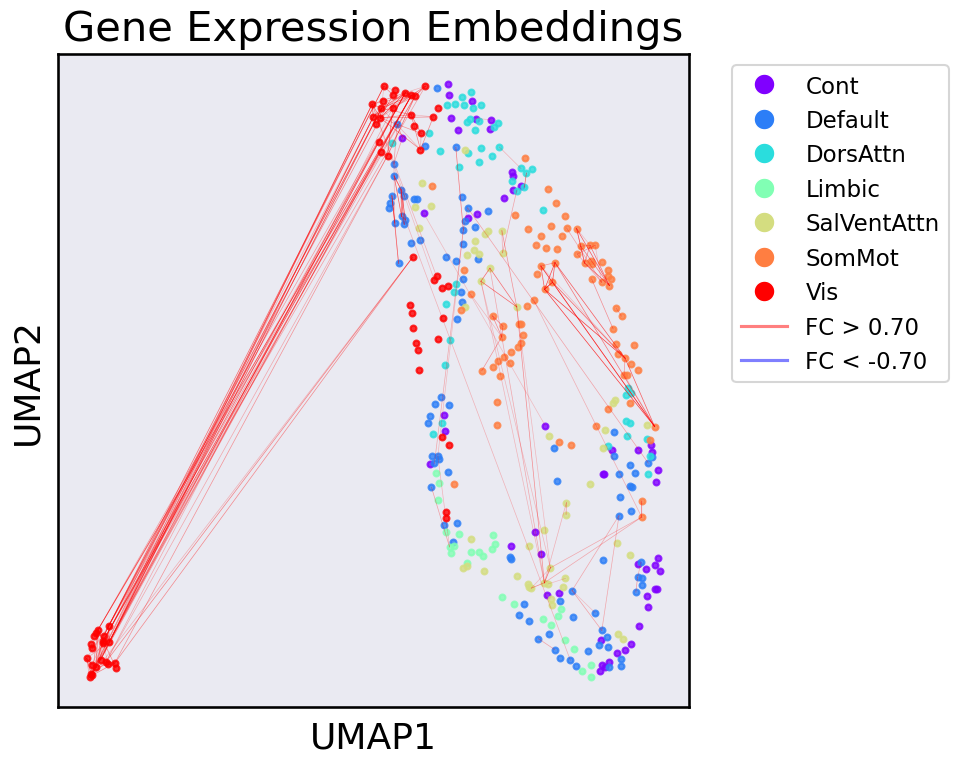

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



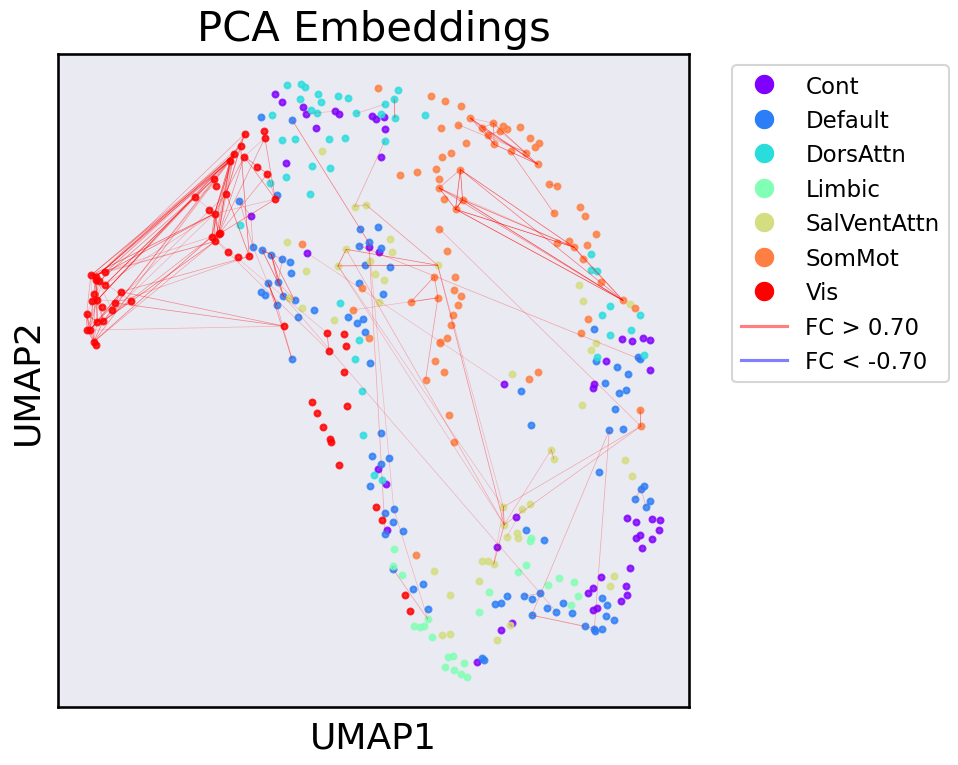

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



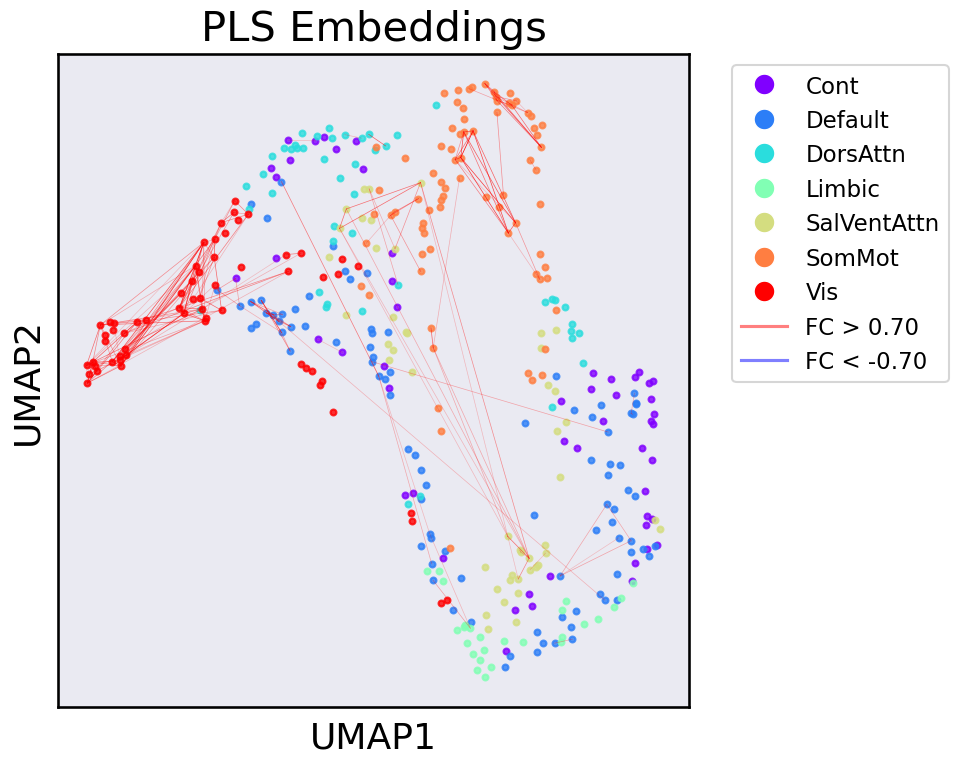

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



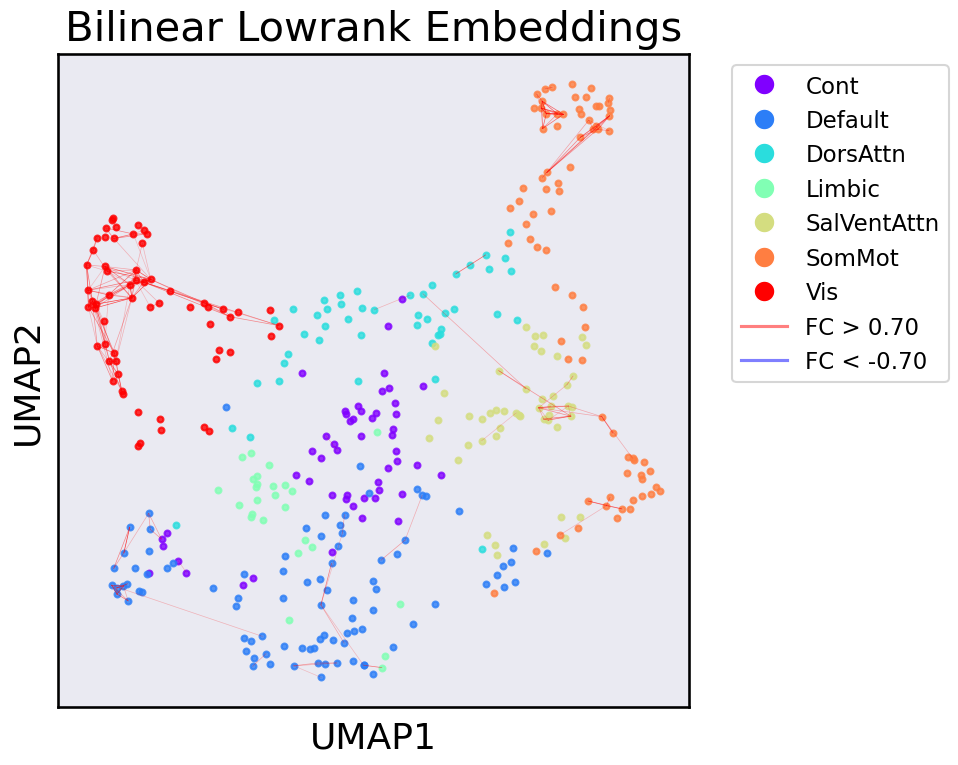

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



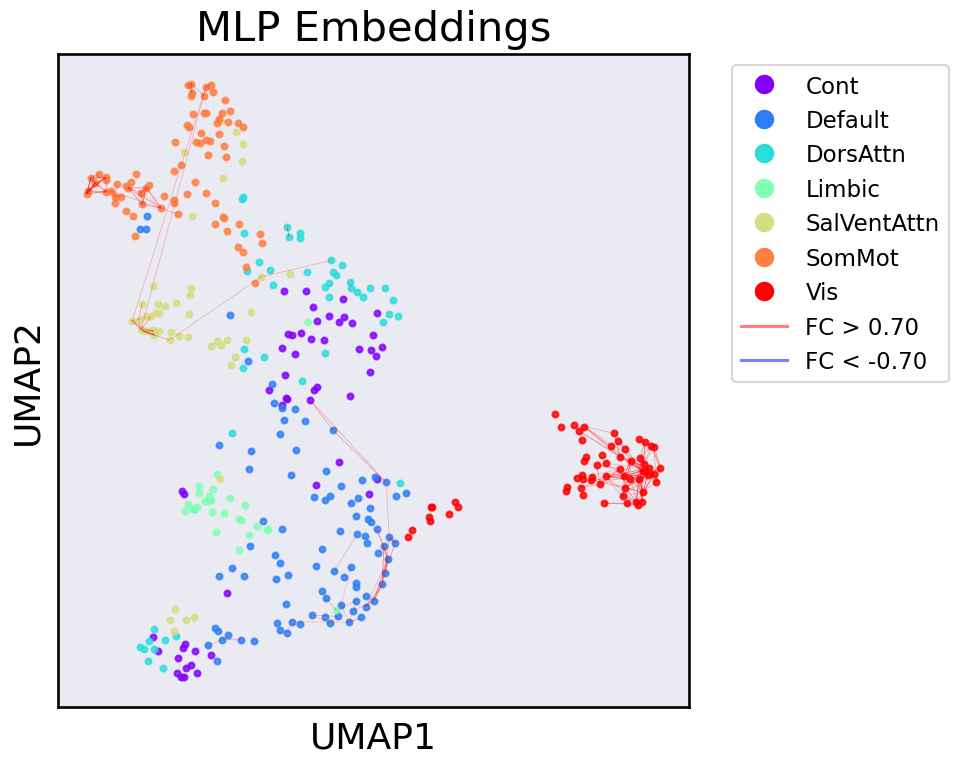

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



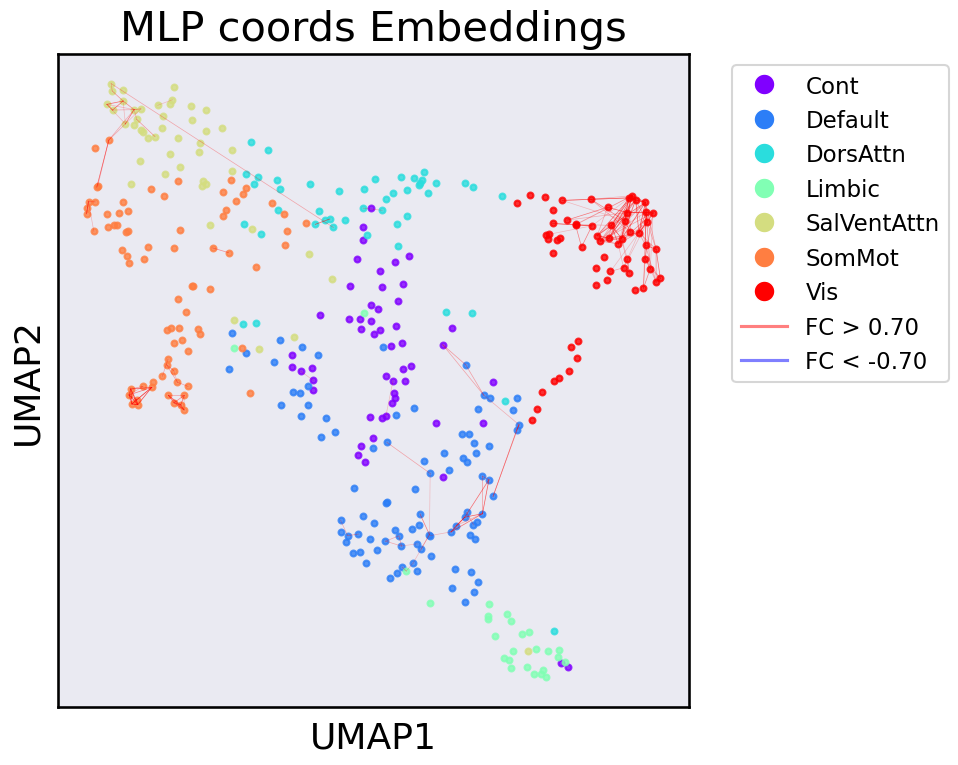

In [32]:
# Plot UMAP visualizations for each embedding type
print("Plotting UMAPs...")

neg_threshold, pos_threshold = -0.7, 0.7
omit_subcortical = True

# Raw gene expression data
plot_umap_embeddings_w_fc(X_valid, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="Gene Expression Embeddings", omit_subcortical=omit_subcortical)

# PCA embeddings 
plot_umap_embeddings_w_fc(X_pca, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="PCA Embeddings", omit_subcortical=omit_subcortical)

# PLS embeddings
plot_umap_embeddings_w_fc(X_pls, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="PLS Embeddings", omit_subcortical=omit_subcortical)

# Bilinear lowrank embeddings
plot_umap_embeddings_w_fc(embeddings_blr, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="Bilinear Lowrank Embeddings", omit_subcortical=omit_subcortical)

# MLP embeddings
plot_umap_embeddings_w_fc(embeddings_mlp, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="MLP Embeddings", omit_subcortical=omit_subcortical)

# MLP coords embeddings
plot_umap_embeddings_w_fc(embeddings_mlpcoords, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="MLP coords Embeddings", omit_subcortical=omit_subcortical)

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



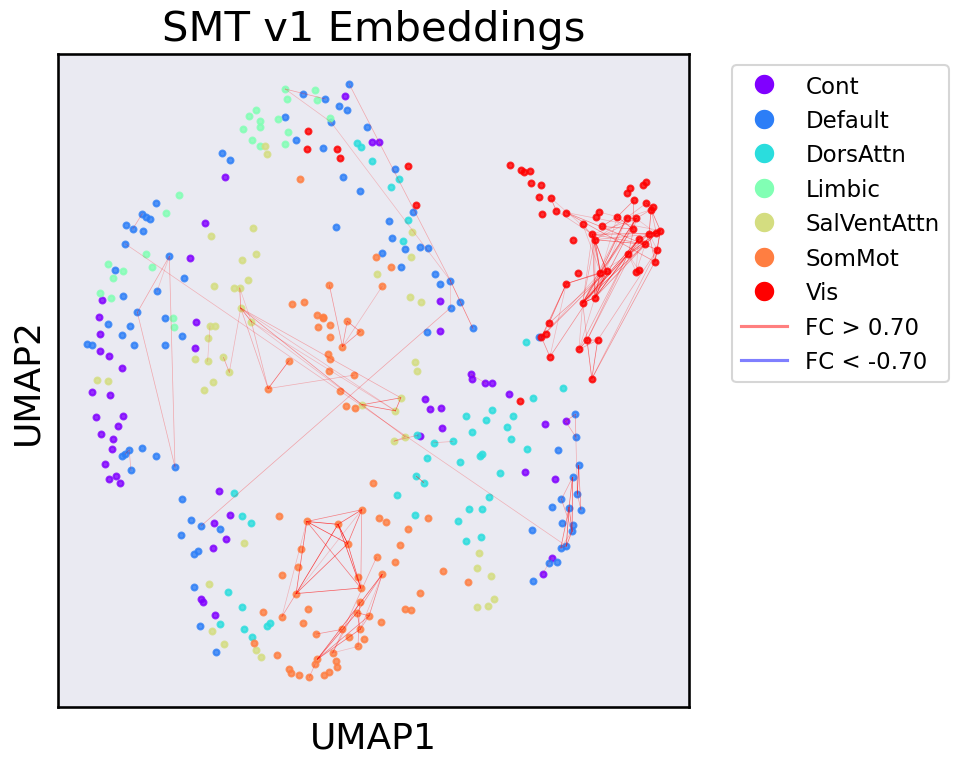

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



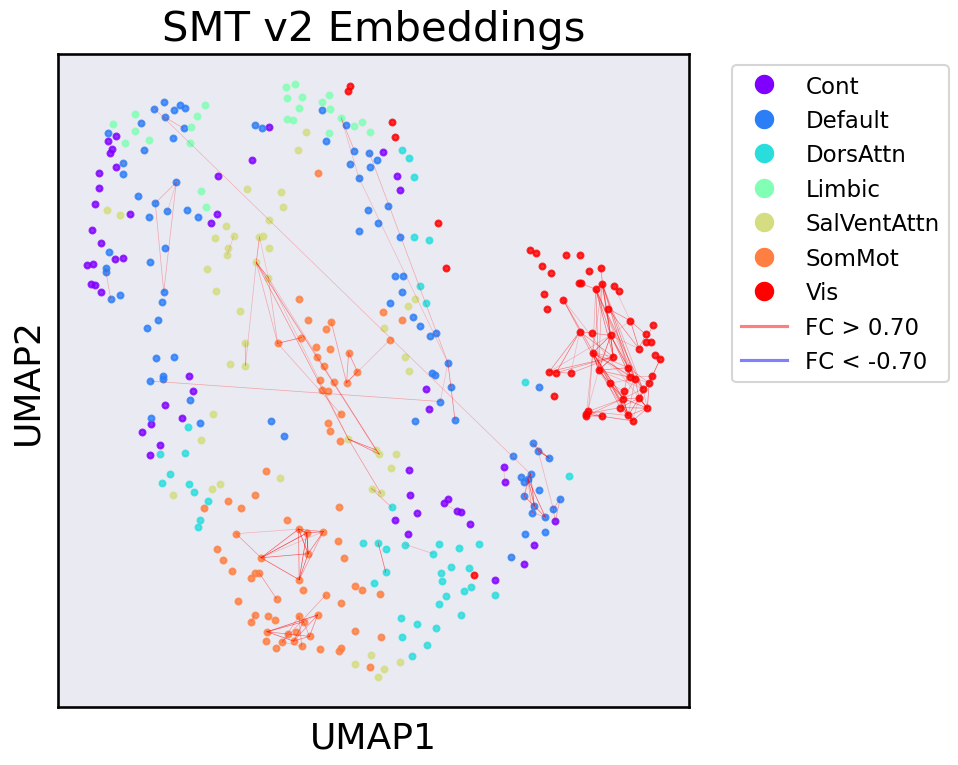

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



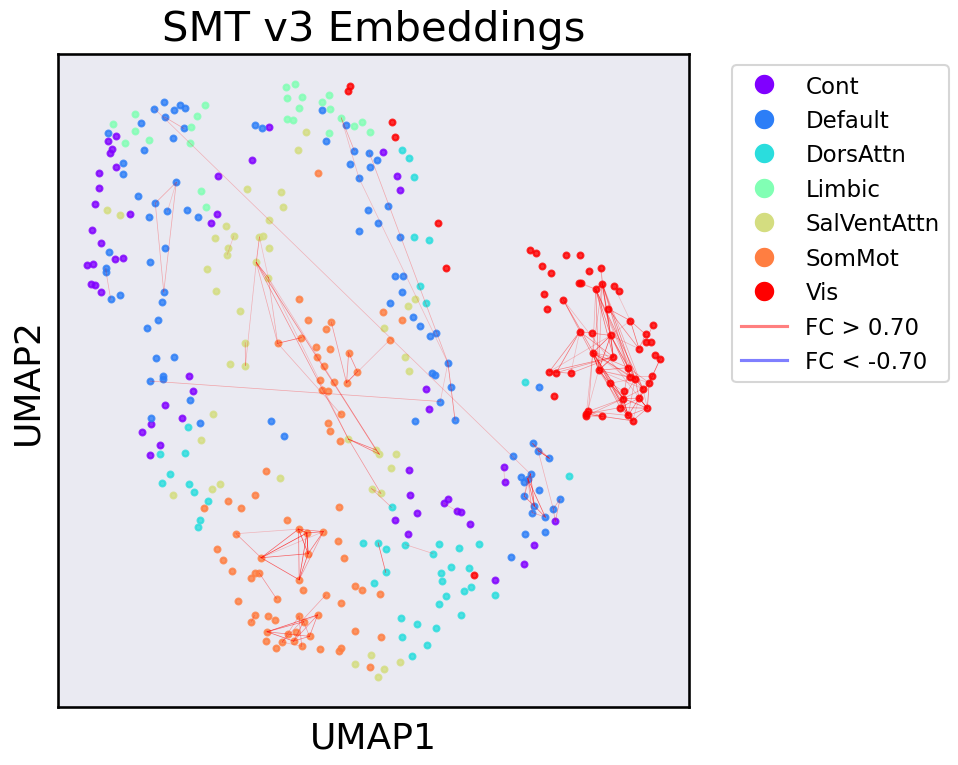

In [33]:
plot_umap_embeddings_w_fc(embeddings_smt_v1, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT v1 Embeddings", omit_subcortical=omit_subcortical)
plot_umap_embeddings_w_fc(embeddings_smt_v2, 
network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT v2 Embeddings", omit_subcortical=omit_subcortical)
plot_umap_embeddings_w_fc(embeddings_smt_v3, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT v3 Embeddings", omit_subcortical=omit_subcortical)


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



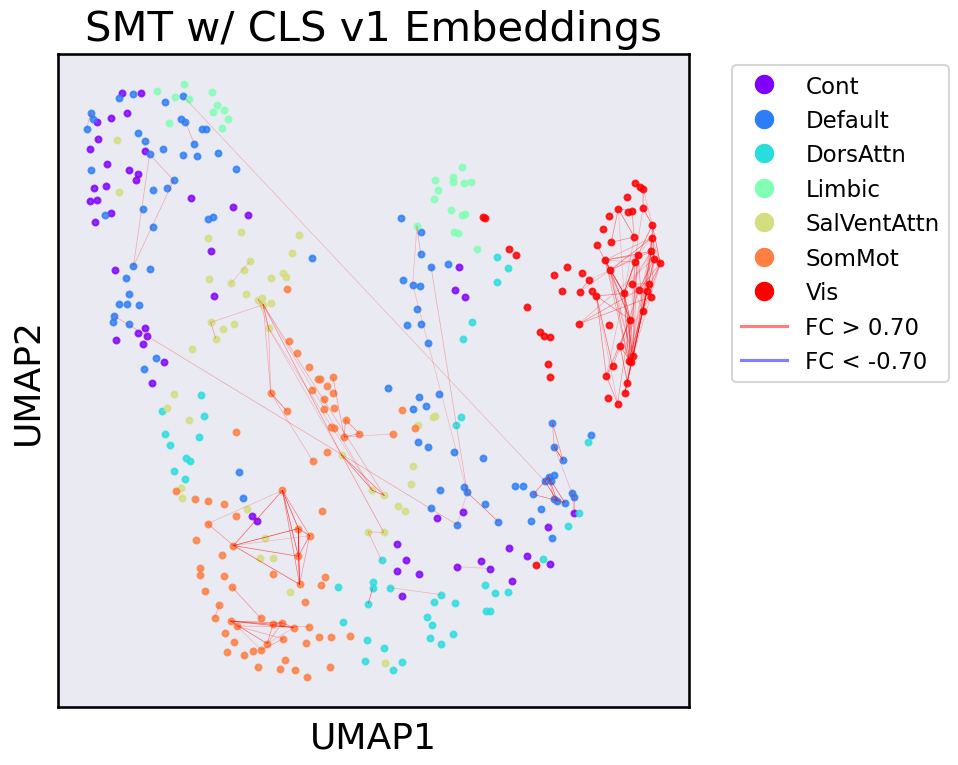

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



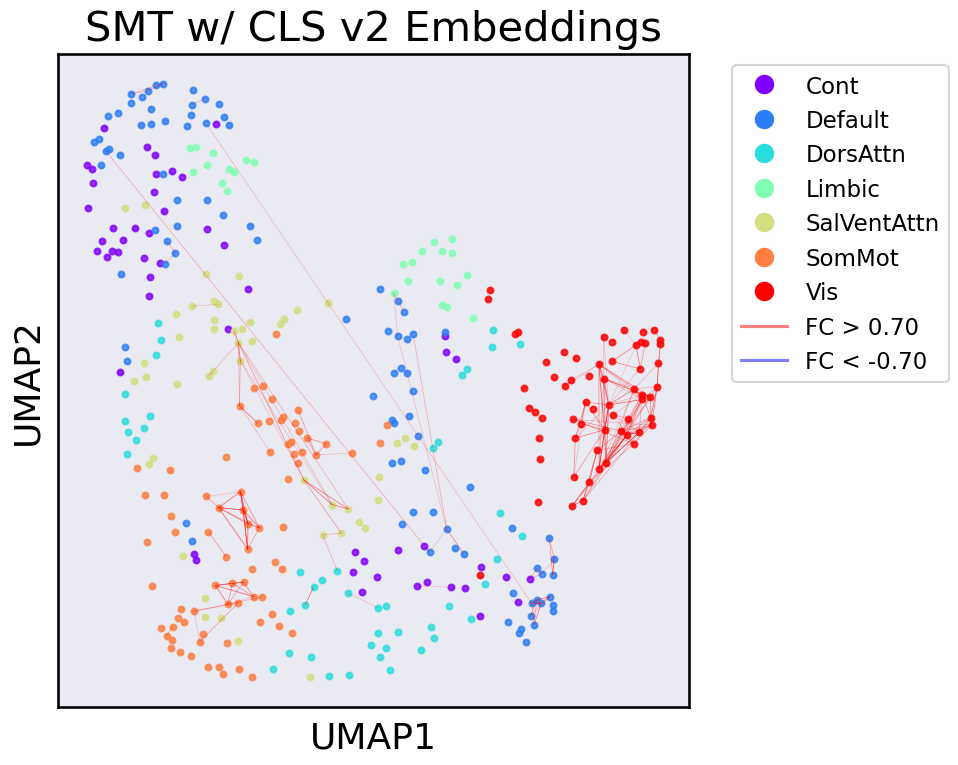

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



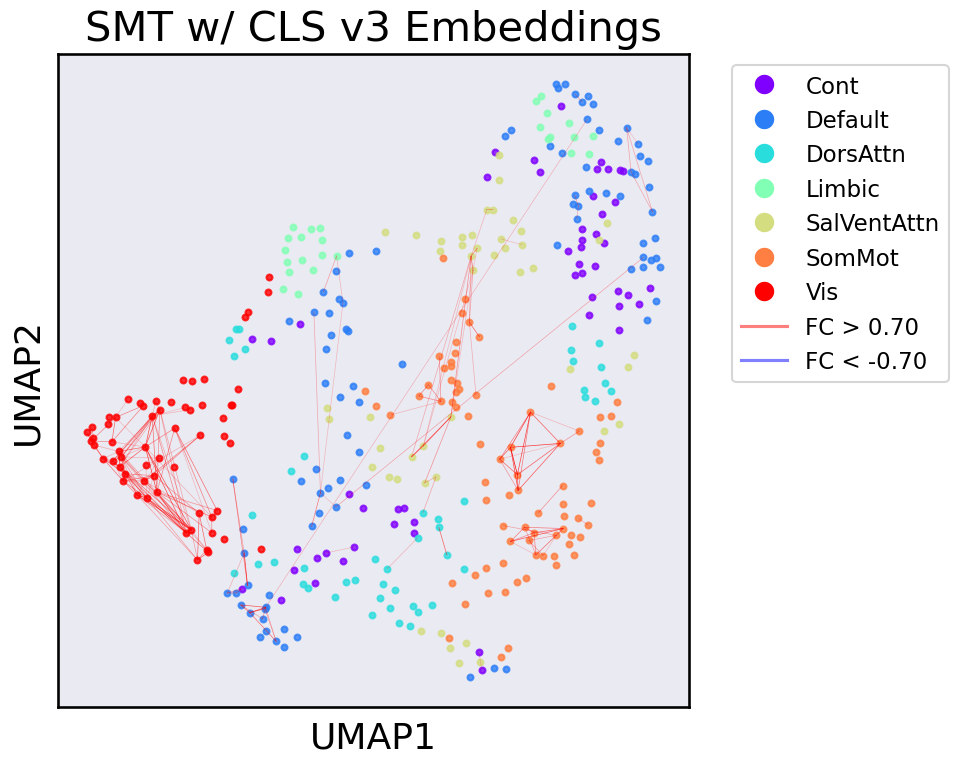

In [34]:
plot_umap_embeddings_w_fc(embeddings_smt_cls_v1, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT w/ CLS v1 Embeddings", omit_subcortical=omit_subcortical)
plot_umap_embeddings_w_fc(embeddings_smt_cls_v2, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT w/ CLS v2 Embeddings", omit_subcortical=omit_subcortical)
plot_umap_embeddings_w_fc(embeddings_smt_cls_v3, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT w/ CLS v3 Embeddings", omit_subcortical=omit_subcortical)


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



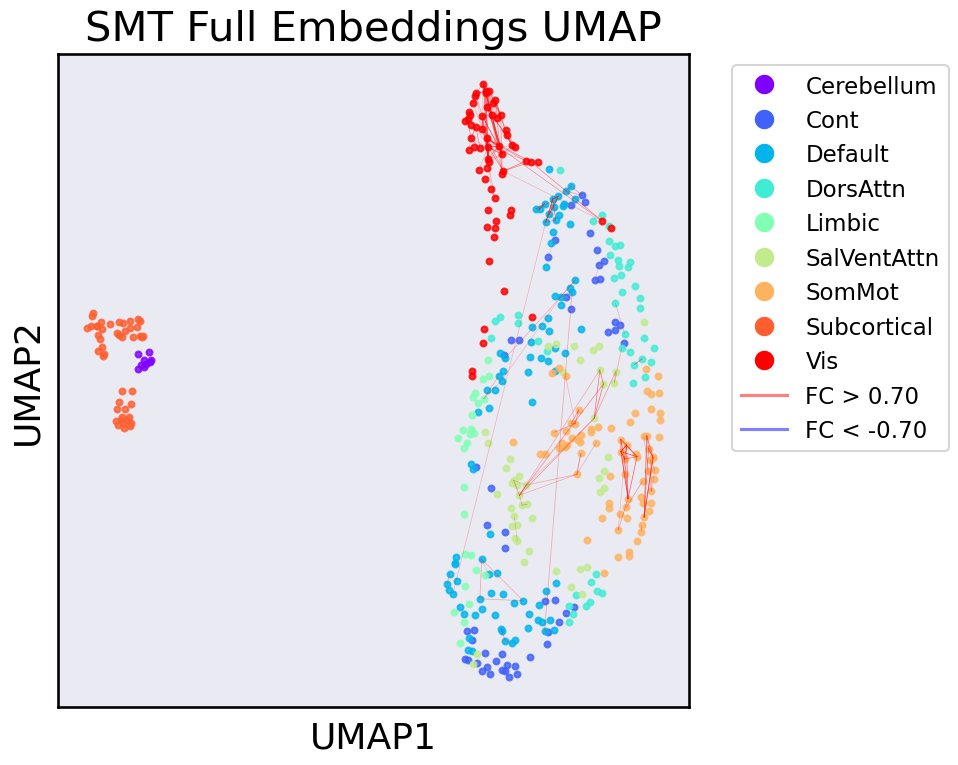

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



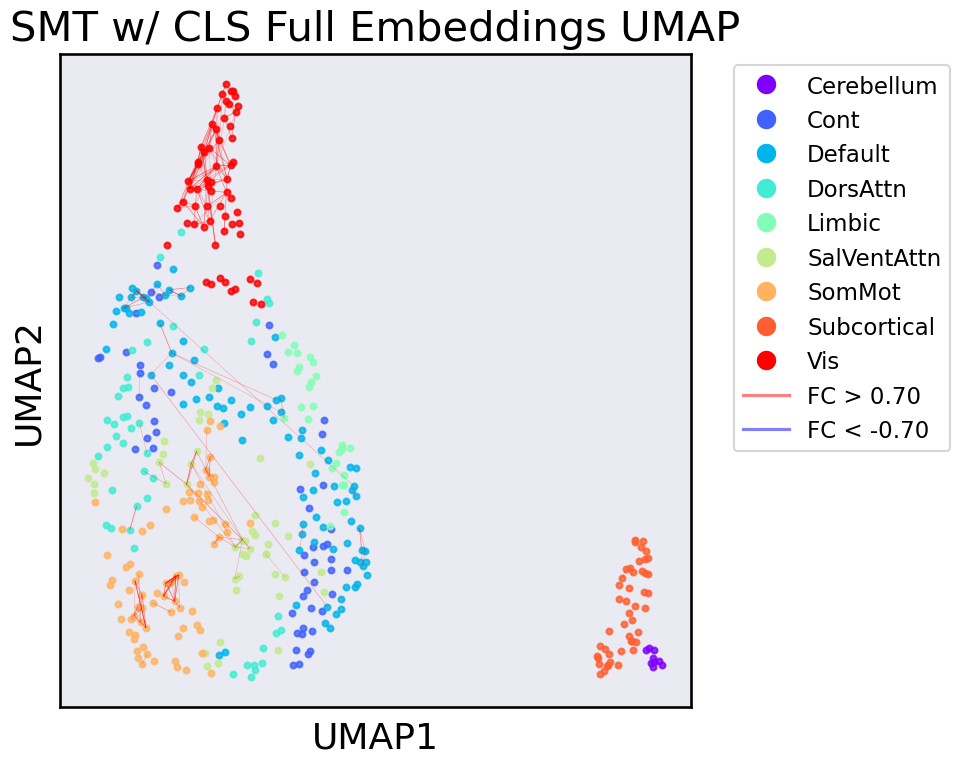

In [23]:
plot_umap_embeddings_w_fc(embeddings_smt_full, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT Full Embeddings UMAP", omit_subcortical=omit_subcortical)
plot_umap_embeddings_w_fc(embeddings_smt_cls_full, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT w/ CLS Full Embeddings UMAP", omit_subcortical=omit_subcortical)

SMT Advanced models

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



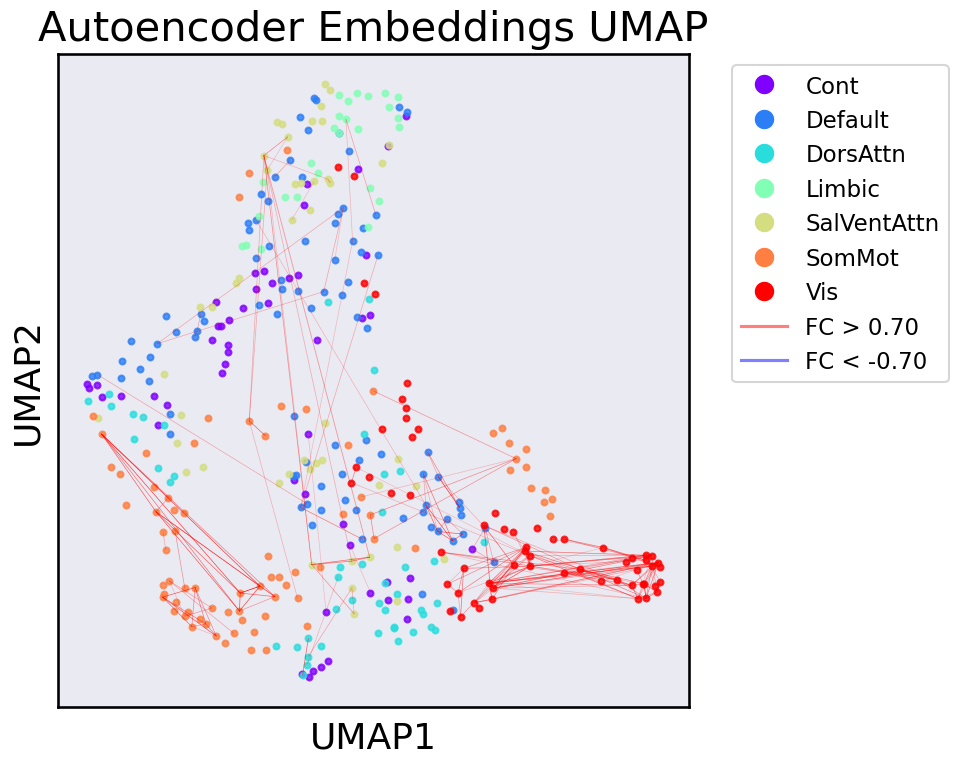

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



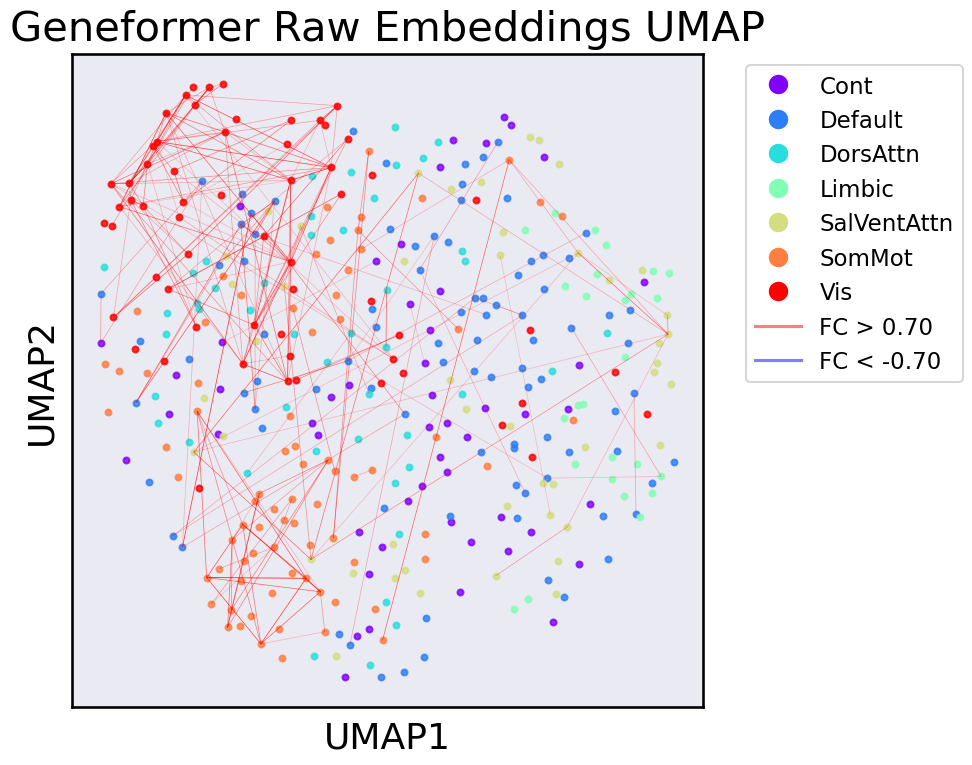

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



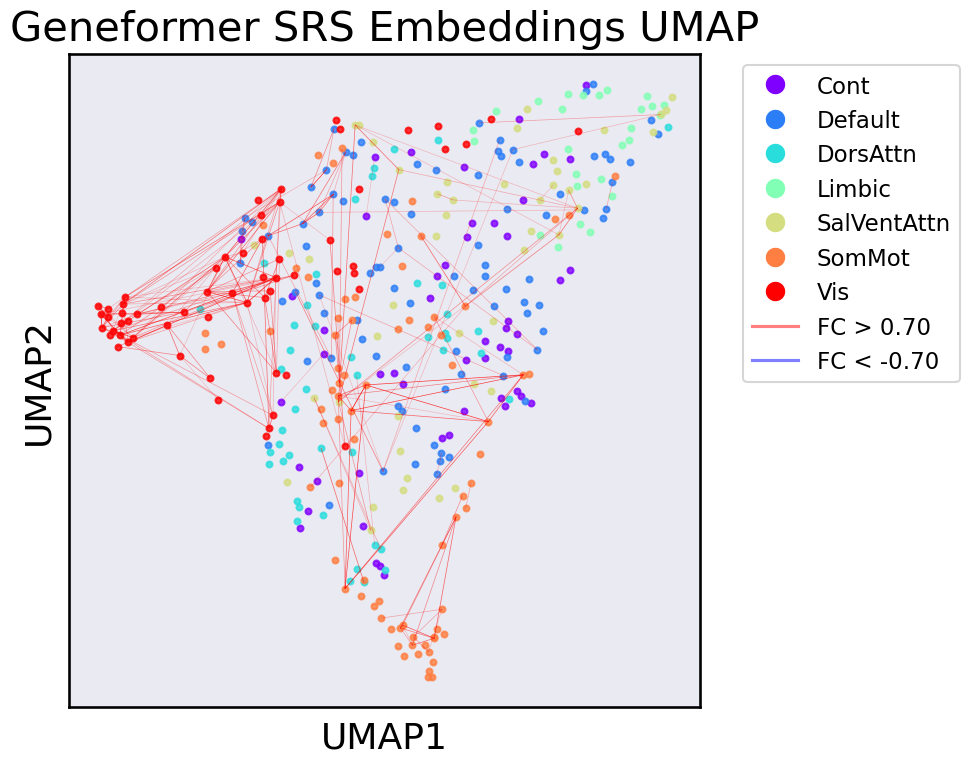

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



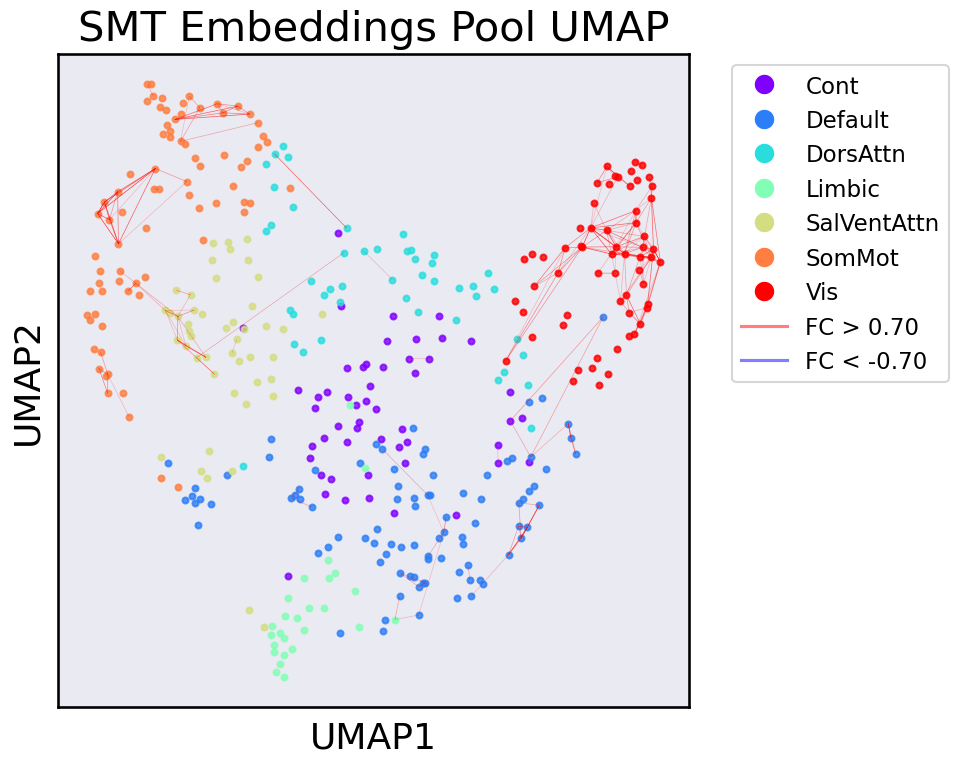

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



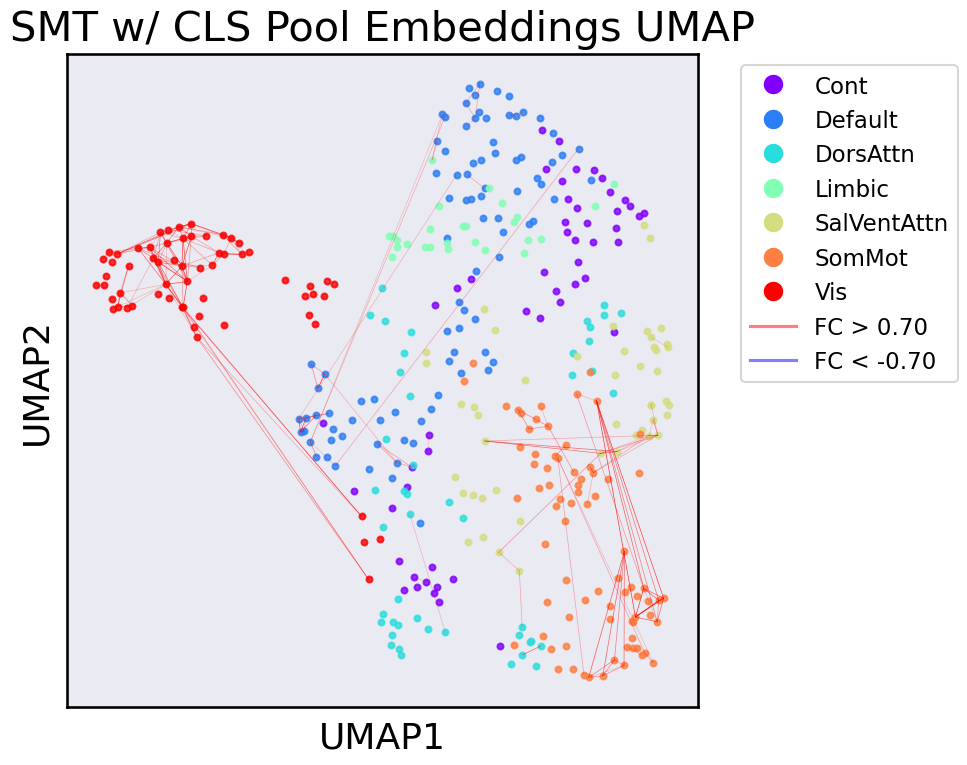

In [35]:
# Autoencoder embeddings
plot_umap_embeddings_w_fc(embeddings_ae, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="Autoencoder Embeddings UMAP", omit_subcortical=omit_subcortical)

# Geneformer raw embeddings
plot_umap_embeddings_w_fc(embeddings_raw, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="Geneformer Raw Embeddings UMAP", omit_subcortical=omit_subcortical)

# Geneformer SRS embeddings  
plot_umap_embeddings_w_fc(embeddings_srs, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="Geneformer SRS Embeddings UMAP", omit_subcortical=omit_subcortical)

# SMT Pool embeddings
plot_umap_embeddings_w_fc(embeddings_smt_pool, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT Embeddings Pool UMAP", omit_subcortical=omit_subcortical)
plot_umap_embeddings_w_fc(embeddings_smt_cls_pool, network_labels, conn_matrix=Y_valid, edge_threshold=(neg_threshold, pos_threshold), title="SMT w/ CLS Pool Embeddings UMAP", omit_subcortical=omit_subcortical)



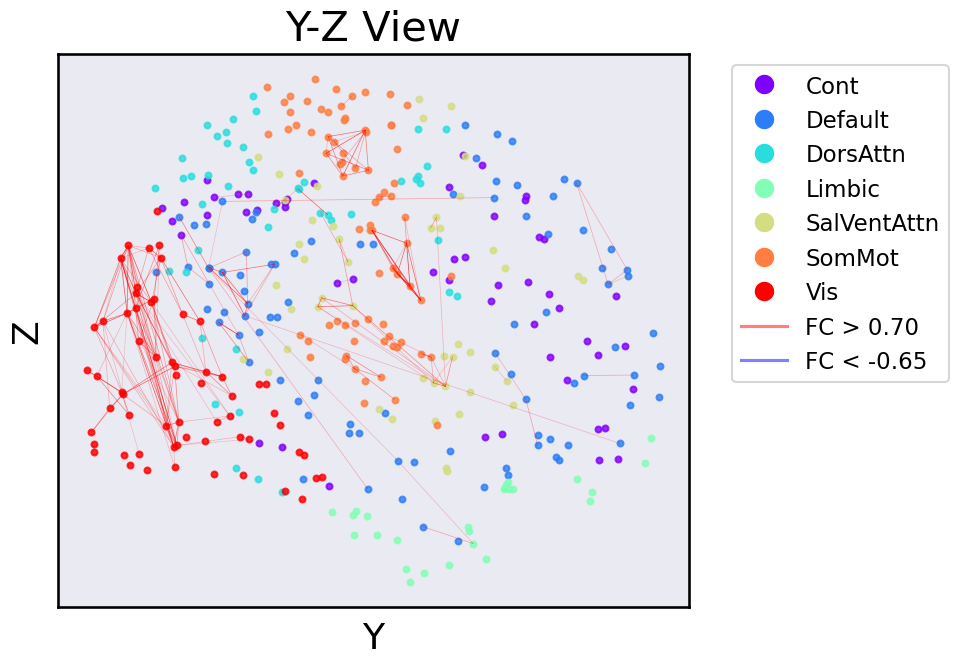

In [36]:
from data.data_viz import plot_coords_w_fc

coords_np = coords.cpu().numpy()
neg_threshold, pos_threshold = -0.65, 0.7

plot_coords_w_fc(coords_np, network_labels, dims=(1,2), conn_matrix=Y_valid, 
                 edge_threshold=(neg_threshold, pos_threshold), 
                 title="Y-Z View",
                 omit_subcortical=omit_subcortical)

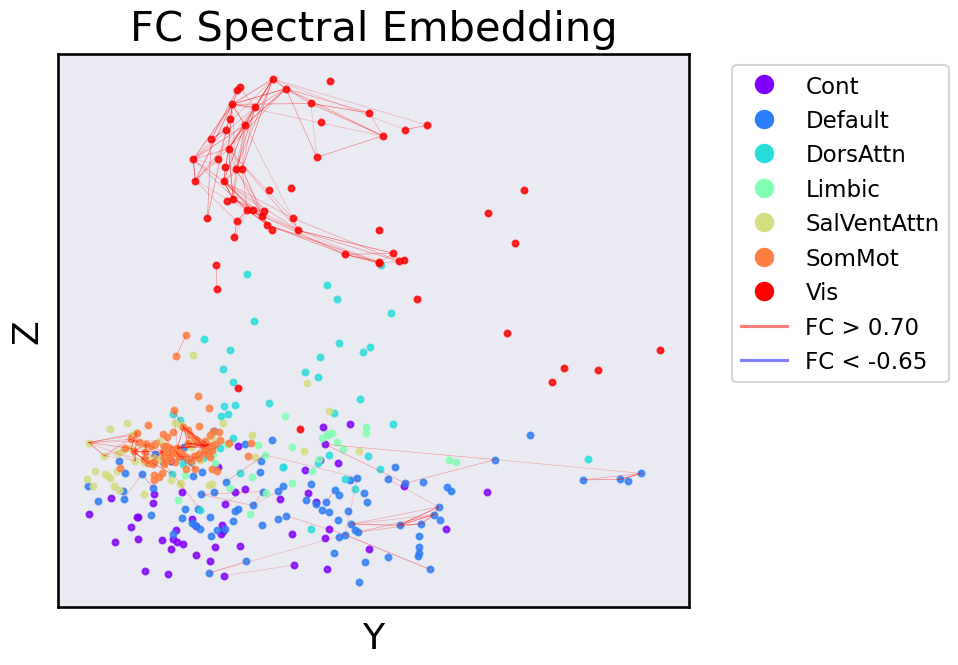

In [37]:
plot_coords_w_fc(Y_valid, network_labels, dims=(1,2), conn_matrix=Y_valid, 
                 edge_threshold=(neg_threshold, pos_threshold), 
                 title="FC Spectral Embedding",
                 omit_subcortical=omit_subcortical)